# Preprocessing

Importing base libraries

In [167]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from scipy.stats import norm
from scipy.stats import norm, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor 
warnings.filterwarnings('ignore')

Reading csv file

In [2]:
data = pd.read_csv('database/hmeq.csv')
# mostrar primeros registros
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Observing that DEROG and DELINQ are integer values, so they are removed from all transformation on numerical features

In [3]:
data['DEROG'] = data['DEROG'].astype(object)
data['DELINQ'] = data['DELINQ'].astype(object)

Dtypes and null values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   object 
 8   DELINQ   5380 non-null   object 
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 605.4+ KB


Dataframe dimension

In [5]:
print(data['BAD'].shape)
print(data['BAD'].unique().shape)

(5960,)
(2,)


Checking on main statistics values

In [6]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,1168.233561,17.000000,71.000000,203.312149


Dividing dataframe into X and y matrices

In [7]:
X = data.drop(columns = 'BAD')
y = data.BAD

Creating a function to replace outliers in order to impute null values afterwards

In [8]:
def clean_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    return df[column].clip(lower = lower_bound, upper = upper_bound)

Before applying outliers detection and removal

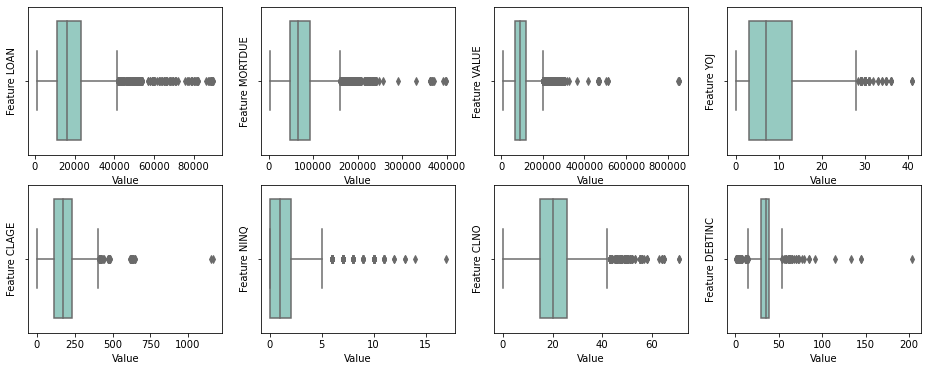

In [9]:
fig, axis = plt.subplots(2, 4, figsize = (16, 6))

actual_columns = X.select_dtypes(include = np.number).columns.tolist()

for index, column in enumerate(actual_columns):
    row = index // 4
    col = index % 4
    ax = axis[row][col]
    sns.boxplot(x = X[column], palette='Set3', ax = ax)
    ax.set_xlabel('Value')
    ax.set_ylabel(f'Feature {column}')
plt.show()

Removing outlliers in numerical columns

In [10]:
for column in actual_columns:
    X[column] = clean_outliers(X, column)

After applyting outliers removal

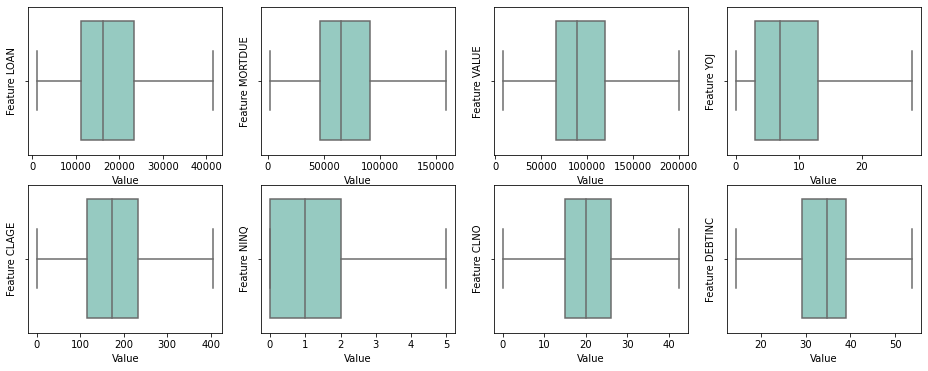

In [11]:
fig, axis = plt.subplots(2, 4, figsize = (16, 6))

actual_columns = X.select_dtypes(include = np.number).columns.tolist()

for index, column in enumerate(actual_columns):
    row = index // 4
    col = index % 4
    ax = axis[row][col]
    sns.boxplot(x = X[column], palette='Set3', ax = ax)
    ax.set_xlabel('Value')
    ax.set_ylabel(f'Feature {column}')
plt.show()

Analyzing distributionS so that it gets easier to decide the imputer

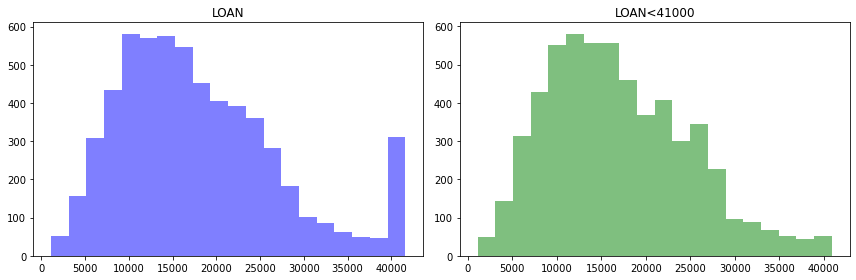

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(X['LOAN'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('LOAN')
axes[1].hist(X[data['LOAN']<41000]['LOAN'], bins=20, color='green', alpha=0.5)
axes[1].set_title('LOAN<41000')
plt.tight_layout()
plt.show()

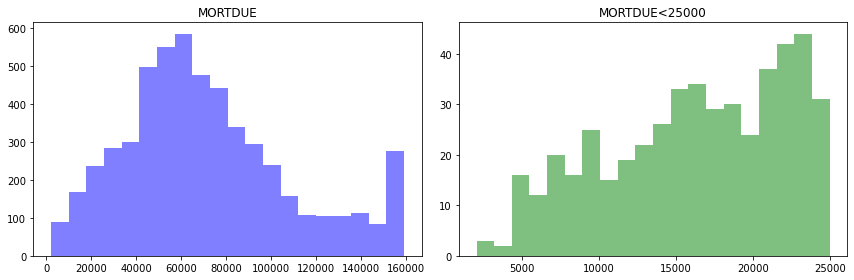

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['MORTDUE'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('MORTDUE')
axes[1].hist(X[X['MORTDUE']<25000]['MORTDUE'], bins=20, color='green', alpha=0.5)
axes[1].set_title('MORTDUE<25000')
plt.tight_layout()
plt.show()

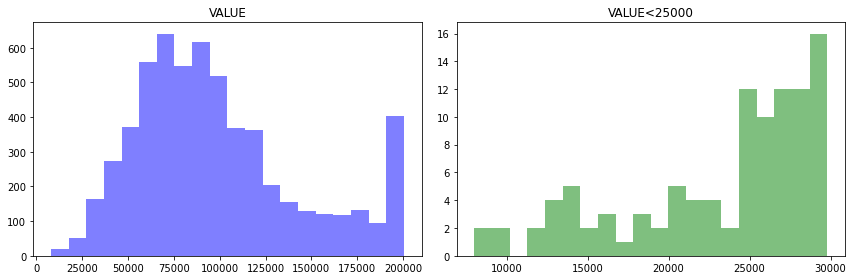

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['VALUE'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('VALUE')
axes[1].hist(X[X['VALUE']<30000]['VALUE'], bins=20, color='green', alpha=0.5)
axes[1].set_title('VALUE<25000')
plt.tight_layout()
plt.show()

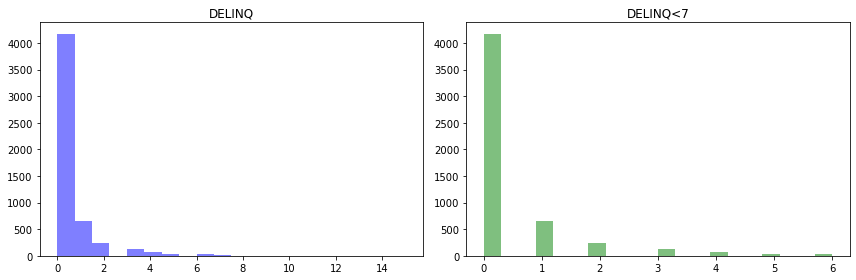

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['DELINQ'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('DELINQ')
axes[1].hist(X[X['DELINQ']<7]['DELINQ'], bins=20, color='green', alpha=0.5)
axes[1].set_title('DELINQ<7')
plt.tight_layout()
plt.show()

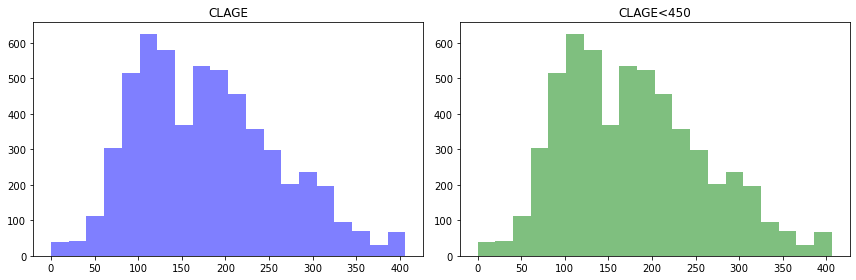

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].hist(X['CLAGE'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('CLAGE')
axes[1].hist(X[X['CLAGE']<450]['CLAGE'], bins=20, color='green', alpha=0.5)
axes[1].set_title('CLAGE<450')
plt.tight_layout()
plt.show()

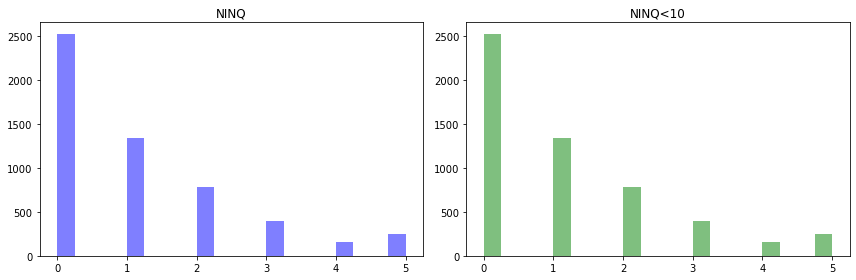

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(X['NINQ'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('NINQ')
axes[1].hist(X[X['NINQ']<10]['NINQ'], bins=20, color='green', alpha=0.5)
axes[1].set_title('NINQ<10')
plt.tight_layout()
plt.show()

Getting back intger features

In [18]:
X['DEROG'] = X['DEROG'].astype(float)
X['DELINQ'] = X['DELINQ'].astype(float)

Imputing X null values with median and encoding cat-object features

In [49]:
# divide columns by their dtype
num_col = X.select_dtypes(include = np.number).columns.tolist()
cat_col = X.select_dtypes(exclude = np.number).columns.tolist()
# declaring imputers
imputer_num = SimpleImputer(strategy = 'median').set_output(transform = 'pandas')
imputer_cat = SimpleImputer(strategy = 'most_frequent').set_output(transform = 'pandas')
# declaring encoders
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')
pipe_encoder = make_pipeline(imputer_cat, encoder)
# declaring all transformations
transformer = ColumnTransformer([('NUM', imputer, num_col), ('CAT', pipe_encoder, cat_col)], remainder = 'passthrough')\
                                .set_output(transform = 'pandas')
# fitting transformer
X_tr = transformer.fit_transform(X)

Verifying there are no null values left

In [50]:
X_tr.isnull().sum().sum()

0

# Modelling

Getting base coefficients by calculating with the whole dataset as a first approach

In [137]:
def bootstrap_confidence_interval_logistic(flow_pipe, X, y, num_simulations = 10000,penalty=penalty_a):
    coefs = []
    num_samples = len(X)
    for _ in range(num_simulations):
        # Muestreo bootstrap
        idx = np.random.choice(range(num_samples), size=num_samples, replace=True)
        X_sampled, y_sampled = X.iloc[idx], y.iloc[idx]
        X_sampled_tr = flow_pipe.fit_transform(X_sampled)
        
        # Ajustar el modelo en la muestra
        if penalty_a=='elasticnet':
            l1_ratio=0.7
            model = LogisticRegression(solver = 'saga',penalty=penalty_a,l1_ratio=0.7)
        else:
            model = LogisticRegression(solver = 'saga',penalty=penalty_a)
        model.fit(X_sampled_tr, y_sampled)
        coefs.append(model.coef_[0])
    
    coefs = np.array(coefs)
    lower_percentile = np.percentile(coefs, 2.5, axis=0)
    upper_percentile = np.percentile(coefs, 97.5, axis=0)
    
    return lower_percentile, upper_percentile

def plot_confidence_intervals(coefficent_names, coefficients, lower_in, upper_in, flag_scaled = True):
    plt.figure(figsize=(10, 6))
    # Plot confidence intervals using lines and error bars
    for i, (name, coef, lower, upper) in enumerate(zip(coefficent_names, coefficients, lower_in, upper_in)):
        plt.plot([i, i], [lower, upper], marker='_', color='orange', markersize=10, linewidth=2, markeredgewidth=2)
        plt.scatter(i, coef, color='red', zorder=5)  # Scatter plot for the actual coefficient
    plt.xlabel('Coefficient Names')
    plt.ylabel('Coefficient Value')
    if flag_scaled:
        plt.title('Coefficient values with confidence intervals')
    else:
        plt.title('Coefficient values with confidence intervals without scaling')
    plt.xticks(range(len(coefficent_names)), coefficent_names, rotation=45, ha='right')
    plt.show()
    
def get_metrics(X, y, estimator, scoring):
    results = cross_validate(estimator = model_pipe,
                             X = X_tr,
                             y = y,
                             cv = 5,
                             scoring = scoring,
                             return_train_score = True)
    train_score = results['train_score'].mean()
    test_score = results['test_score'].mean()
    return train_score, test_score

## Clasico

In [146]:
penalty_a='none'
model = LogisticRegression(solver = 'saga', random_state = 23,penalty=penalty_a)
model_pipe = make_pipeline(StandardScaler(), model)
model_pipe.fit(X_tr, y)

coefficients = model_pipe[-1].coef_[0]
print("Intercept:", model_pipe[-1].intercept_[0])
print("Coefficients:", model_pipe[-1].coef_[0])

Intercept: -1.7324079267998171
Coefficients: [-0.19249319 -0.12892455  0.02992212 -0.05906357  0.46182721  0.83100744
 -0.46307188  0.2908601  -0.17233612  0.4807517  -0.05761684  0.05761684
  0.01398439 -0.22025237  0.02436043  0.0527566   0.14594369  0.12745904]


In [147]:
# getting confidence interval from coefficents
flow_pipe = make_pipeline(transformer, StandardScaler())
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(flow_pipe, X, y,1000,'none')
print("Coefficient Confidence Intervals")
print("Lower bound:", lower_ci)
print("Upper bound:", upper_ci)

Coefficient Confidence Intervals
Lower bound: [-0.2761795  -0.27053893 -0.11255454 -0.15531437  0.39041415  0.73967588
 -0.55506142  0.21857155 -0.27129823  0.39156961 -0.097457    0.01442454
 -0.05173399 -0.29039485 -0.02682694 -0.00664518  0.07273962  0.06861648]
Upper bound: [-0.10172741  0.01925231  0.16777603  0.02395529  0.55736829  0.94373042
 -0.38737123  0.3611275  -0.09026114  0.58174156 -0.01442454  0.097457
  0.07315111 -0.14809041  0.07598292  0.11289671  0.21724777  0.18553248]


In [148]:
bootstrap = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5%': lower_ci,
                          '97.5%': upper_ci})

bootstrap

,Feature,Coefficient,2.5%,97.5%
0,NUM__LOAN,-0.192493,-0.276179,-0.101727
1,NUM__MORTDUE,-0.128925,-0.270539,0.019252
2,NUM__VALUE,0.029922,-0.112555,0.167776
3,NUM__YOJ,-0.059064,-0.155314,0.023955
4,NUM__DEROG,0.461827,0.390414,0.557368
5,NUM__DELINQ,0.831007,0.739676,0.943730
6,NUM__CLAGE,-0.463072,-0.555061,-0.387371
7,NUM__NINQ,0.290860,0.218572,0.361128
8,NUM__CLNO,-0.172336,-0.271298,-0.090261
9,NUM__DEBTINC,0.480752,0.391570,0.581742


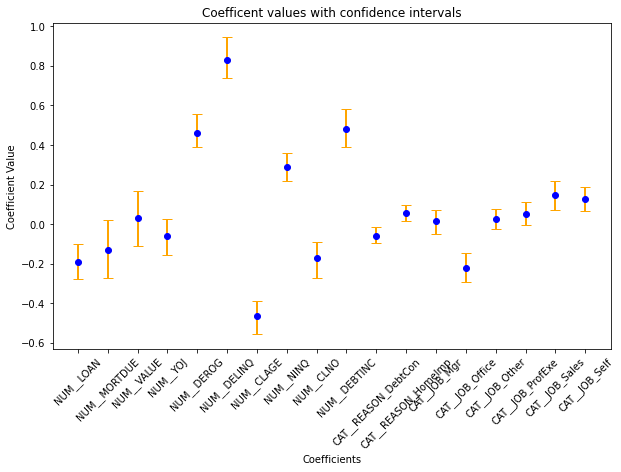

In [149]:
coefficent_names = X_tr.columns
plt.figure(figsize=(10, 6))

plt.errorbar(coefficent_names, coefficients, yerr = [coefficients - lower_ci, upper_ci - coefficients],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coefficients')
plt.ylabel('Coefficient Value')
plt.title('Coefficent values with confidence intervals')

plt.xticks(rotation=45)
plt.savefig("Imagen_Intervalos.png")
plt.show()

In [150]:
# calculating the probabilities
X_sc = model_pipe[0].transform(X_tr)
prob = model_pipe.predict_proba(X_tr)[:, 1]
# getting covariate matrix
W = np.diag(prob * (1 - prob))
# calculating the standard deviation
std = np.sqrt(np.diag(np.linalg.pinv(np.dot(np.dot(X_sc.T, W), X_sc))))
# getting confidence intervals
lower_interval = coefficients - np.abs(norm.ppf(0.025)) * std
upper_interval = coefficients + np.abs(norm.ppf(0.025)) * std

In [151]:
intervalos = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5% Boost': lower_ci,
                          '97.5% Boost': upper_ci,
                          '2.5% Mate': lower_interval,
                          '97.5% Mate': upper_interval})

intervalos

,Feature,Coefficient,2.5% Boost,97.5% Boost,2.5% Mate,97.5% Mate
0,NUM__LOAN,-0.192493,-0.276179,-0.101727,-0.277422,-0.107564
1,NUM__MORTDUE,-0.128925,-0.270539,0.019252,-0.265806,0.007957
2,NUM__VALUE,0.029922,-0.112555,0.167776,-0.112853,0.172698
3,NUM__YOJ,-0.059064,-0.155314,0.023955,-0.141326,0.023199
4,NUM__DEROG,0.461827,0.390414,0.557368,0.385270,0.538384
5,NUM__DELINQ,0.831007,0.739676,0.943730,0.750761,0.911254
6,NUM__CLAGE,-0.463072,-0.555061,-0.387371,-0.546436,-0.379707
7,NUM__NINQ,0.290860,0.218572,0.361128,0.221511,0.360209
8,NUM__CLNO,-0.172336,-0.271298,-0.090261,-0.256671,-0.088002
9,NUM__DEBTINC,0.480752,0.391570,0.581742,0.396107,0.565397


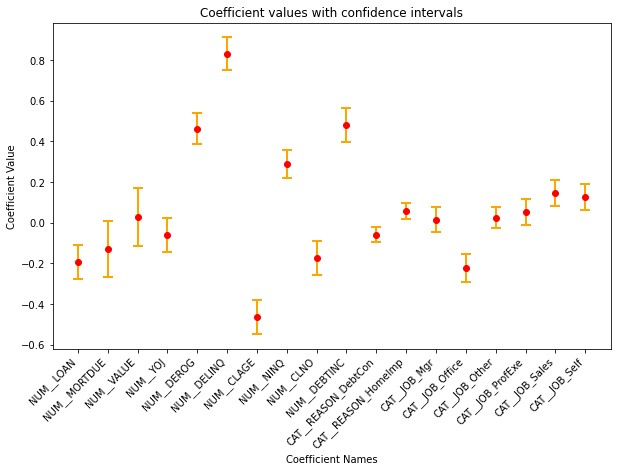

In [152]:
plot_confidence_intervals(coefficent_names, coefficients, lower_interval, upper_interval, flag_scaled = True)

In [153]:
train_scores = list()
test_scores = list()
scores = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
for score in scores:
    train_score, test_score = get_metrics(X_tr, y, model_pipe, score)
    train_scores.append(train_score)
    test_scores.append(test_score)
metrics = pd.DataFrame({'Metric': scores,
                        'Train': train_scores,
                        'Test': test_scores})
display(metrics)

,Metric,Train,Test
0,accuracy,0.841275,0.836074
1,recall,0.330527,0.308574
2,precision,0.723557,0.754244
3,f1,0.453520,0.425126
4,roc_auc,0.809492,0.785519


### L2

In [106]:
penalty_a='l2'
model = LogisticRegression(solver = 'saga', random_state = 23,penalty=penalty_a)
model_pipe = make_pipeline(StandardScaler(), model)
model_pipe.fit(X_tr, y)

coefficients = model_pipe[-1].coef_[0]
print("Intercept:", model_pipe[-1].intercept_[0])
print("Coefficients:", model_pipe[-1].coef_[0])

Intercept: -1.7314416195819293
Coefficients: [-0.19208438 -0.12798517  0.02889943 -0.0590351   0.46111439  0.82929222
 -0.46214212  0.29050586 -0.17168995  0.47948417 -0.05760256  0.05760256
  0.01401274 -0.21969569  0.02435911  0.05240274  0.14570055  0.12726298]


Doing the same thing by applying bootstrap

In [110]:
# getting confidence interval from coefficents
flow_pipe = make_pipeline(transformer, StandardScaler())
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(flow_pipe, X, y,1000,'l2')
print("Coefficient Confidence Intervals")
print("Lower bound:", lower_ci)
print("Upper bound:", upper_ci)

Coefficient Confidence Intervals
Lower bound: [-0.28570454 -0.26934292 -0.10612962 -0.14068034  0.38930738  0.73027864
 -0.55093803  0.21787953 -0.26760385  0.38122115 -0.09758346  0.02051176
 -0.05267707 -0.2912649  -0.02527218 -0.00734244  0.07049089  0.06486818]
Upper bound: [-0.09353653  0.00433682  0.16203128  0.0285825   0.55060767  0.93566017
 -0.37708545  0.36577598 -0.0814108   0.57455362 -0.02051176  0.09758346
  0.07720053 -0.15492033  0.07787613  0.1145985   0.21351357  0.18510153]


Putting all together into a table

In [111]:
bootstrap = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5%': lower_ci,
                          '97.5%': upper_ci})

bootstrap

,Feature,Coefficient,2.5%,97.5%
0,NUM__LOAN,-0.192084,-0.285705,-0.093537
1,NUM__MORTDUE,-0.127985,-0.269343,0.004337
2,NUM__VALUE,0.028899,-0.106130,0.162031
3,NUM__YOJ,-0.059035,-0.140680,0.028583
4,NUM__DEROG,0.461114,0.389307,0.550608
5,NUM__DELINQ,0.829292,0.730279,0.935660
6,NUM__CLAGE,-0.462142,-0.550938,-0.377085
7,NUM__NINQ,0.290506,0.217880,0.365776
8,NUM__CLNO,-0.171690,-0.267604,-0.081411
9,NUM__DEBTINC,0.479484,0.381221,0.574554


Plotting coefficients with their confidence intervals

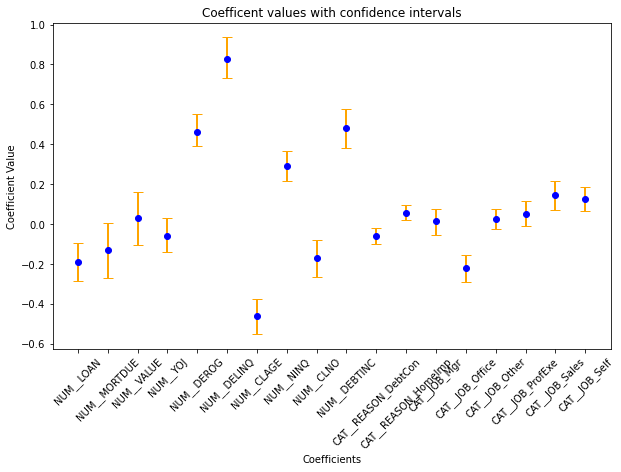

In [112]:
coefficent_names = X_tr.columns
plt.figure(figsize=(10, 6))

plt.errorbar(coefficent_names, coefficients, yerr = [coefficients - lower_ci, upper_ci - coefficients],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coefficients')
plt.ylabel('Coefficient Value')
plt.title('Coefficent values with confidence intervals')

plt.xticks(rotation=45)
plt.savefig("Imagen_Intervalos.png")
plt.show()

In [113]:
# calculating the probabilities
X_sc = model_pipe[0].transform(X_tr)
prob = model_pipe.predict_proba(X_tr)[:, 1]
# getting covariate matrix
W = np.diag(prob * (1 - prob))
# calculating the standard deviation
std = np.sqrt(np.diag(np.linalg.pinv(np.dot(np.dot(X_sc.T, W), X_sc))))
# getting confidence intervals
lower_interval = coefficients - np.abs(norm.ppf(0.025)) * std
upper_interval = coefficients + np.abs(norm.ppf(0.025)) * std

In [114]:
intervalos = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5% Boost': lower_ci,
                          '97.5% Boost': upper_ci,
                          '2.5% Mate': lower_interval,
                          '97.5% Mate': upper_interval})

intervalos

,Feature,Coefficient,2.5% Boost,97.5% Boost,2.5% Mate,97.5% Mate
0,NUM__LOAN,-0.192084,-0.285705,-0.093537,-0.276978,-0.107191
1,NUM__MORTDUE,-0.127985,-0.269343,0.004337,-0.264799,0.008829
2,NUM__VALUE,0.028899,-0.106130,0.162031,-0.113802,0.171601
3,NUM__YOJ,-0.059035,-0.140680,0.028583,-0.141257,0.023187
4,NUM__DEROG,0.461114,0.389307,0.550608,0.384611,0.537618
5,NUM__DELINQ,0.829292,0.730279,0.935660,0.749124,0.909460
6,NUM__CLAGE,-0.462142,-0.550938,-0.377085,-0.545470,-0.378814
7,NUM__NINQ,0.290506,0.217880,0.365776,0.221177,0.359835
8,NUM__CLNO,-0.171690,-0.267604,-0.081411,-0.255987,-0.087393
9,NUM__DEBTINC,0.479484,0.381221,0.574554,0.394885,0.564083


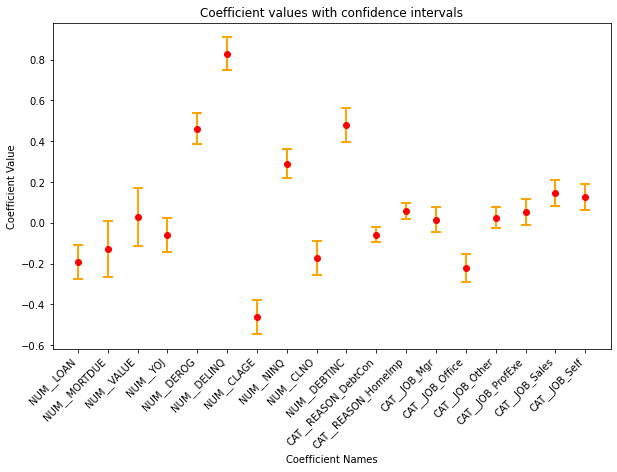

In [115]:
plot_confidence_intervals(coefficent_names, coefficients, lower_interval, upper_interval, flag_scaled = True)

##### Verifyng Metrics L2

In [118]:
train_scores = list()
test_scores = list()
scores = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
for score in scores:
    train_score, test_score = get_metrics(X_tr, y, model_pipe, score)
    train_scores.append(train_score)
    test_scores.append(test_score)
metrics = pd.DataFrame({'Metric': scores,
                        'Train': train_scores,
                        'Test': test_scores})
display(metrics)

,Metric,Train,Test
0,accuracy,0.841317,0.836242
1,recall,0.329897,0.308574
2,precision,0.724517,0.755726
3,f1,0.453115,0.425372
4,roc_auc,0.809498,0.785581


## L1

In [120]:
penalty_a='l1'
model = LogisticRegression(solver = 'saga', random_state = 23,penalty=penalty_a)
model_pipe = make_pipeline(StandardScaler(), model)
model_pipe.fit(X_tr, y)

coefficients = model_pipe[-1].coef_[0]
print("Intercept:", model_pipe[-1].intercept_[0])
print("Coefficients:", model_pipe[-1].coef_[0])

Intercept: -1.730001500781728
Coefficients: [-0.18999941 -0.11949603  0.01986609 -0.0572296   0.45999651  0.82797122
 -0.46144522  0.28912212 -0.17014112  0.47775722 -0.05722748  0.05722748
 -0.00146297 -0.2359722   0.          0.0307242   0.13812173  0.11809175]


In [122]:
# getting confidence interval from coefficents
flow_pipe = make_pipeline(transformer, StandardScaler())
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(flow_pipe, X, y,1000,'l1')
print("Coefficient Confidence Intervals")
print("Lower bound:", lower_ci)
print("Upper bound:", upper_ci)

Coefficient Confidence Intervals
Lower bound: [-0.28674827 -0.26657867 -0.12151075 -0.14364193  0.38586576  0.74325859
 -0.54890576  0.21546193 -0.26355954  0.38961024 -0.09735308  0.0143069
 -0.06600158 -0.34194831 -0.08711841 -0.0351187   0.05421903  0.04703058]
Upper bound: [-9.52445261e-02  2.09935272e-05  1.56845621e-01  2.05973214e-02
  5.51530127e-01  9.27012688e-01 -3.82319579e-01  3.60565048e-01
 -8.10620597e-02  5.78497869e-01 -1.43068982e-02  9.73530765e-02
  4.54297157e-02 -1.56375402e-01  4.93565953e-02  9.39204693e-02
  2.07977842e-01  1.79213456e-01]


In [123]:
bootstrap = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5%': lower_ci,
                          '97.5%': upper_ci})

bootstrap

,Feature,Coefficient,2.5%,97.5%
0,NUM__LOAN,-0.189999,-0.286748,-0.095245
1,NUM__MORTDUE,-0.119496,-0.266579,0.000021
2,NUM__VALUE,0.019866,-0.121511,0.156846
3,NUM__YOJ,-0.057230,-0.143642,0.020597
4,NUM__DEROG,0.459997,0.385866,0.551530
5,NUM__DELINQ,0.827971,0.743259,0.927013
6,NUM__CLAGE,-0.461445,-0.548906,-0.382320
7,NUM__NINQ,0.289122,0.215462,0.360565
8,NUM__CLNO,-0.170141,-0.263560,-0.081062
9,NUM__DEBTINC,0.477757,0.389610,0.578498


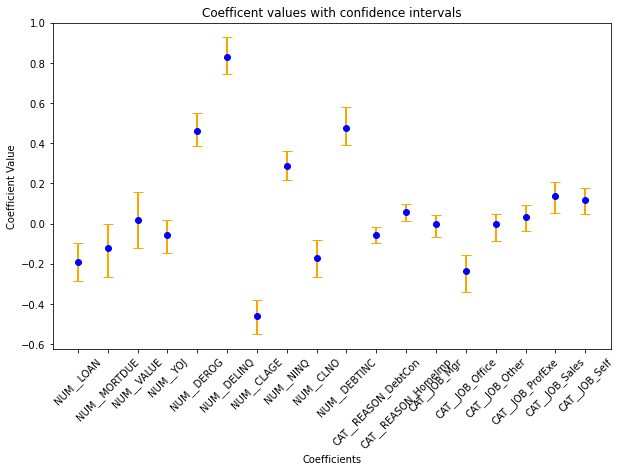

In [124]:
coefficent_names = X_tr.columns
plt.figure(figsize=(10, 6))

plt.errorbar(coefficent_names, coefficients, yerr = [coefficients - lower_ci, upper_ci - coefficients],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coefficients')
plt.ylabel('Coefficient Value')
plt.title('Coefficent values with confidence intervals')

plt.xticks(rotation=45)
plt.savefig("Imagen_Intervalos.png")
plt.show()

In [125]:
# calculating the probabilities
X_sc = model_pipe[0].transform(X_tr)
prob = model_pipe.predict_proba(X_tr)[:, 1]
# getting covariate matrix
W = np.diag(prob * (1 - prob))
# calculating the standard deviation
std = np.sqrt(np.diag(np.linalg.pinv(np.dot(np.dot(X_sc.T, W), X_sc))))
# getting confidence intervals
lower_interval = coefficients - np.abs(norm.ppf(0.025)) * std
upper_interval = coefficients + np.abs(norm.ppf(0.025)) * std

In [126]:
intervalos = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5% Boost': lower_ci,
                          '97.5% Boost': upper_ci,
                          '2.5% Mate': lower_interval,
                          '97.5% Mate': upper_interval})

intervalos

,Feature,Coefficient,2.5% Boost,97.5% Boost,2.5% Mate,97.5% Mate
0,NUM__LOAN,-0.189999,-0.286748,-0.095245,-0.274824,-0.105175
1,NUM__MORTDUE,-0.119496,-0.266579,0.000021,-0.256141,0.017149
2,NUM__VALUE,0.019866,-0.121511,0.156846,-0.122632,0.162364
3,NUM__YOJ,-0.057230,-0.143642,0.020597,-0.139374,0.024915
4,NUM__DEROG,0.459997,0.385866,0.551530,0.383580,0.536413
5,NUM__DELINQ,0.827971,0.743259,0.927013,0.747880,0.908062
6,NUM__CLAGE,-0.461445,-0.548906,-0.382320,-0.544754,-0.378137
7,NUM__NINQ,0.289122,0.215462,0.360565,0.219813,0.358431
8,NUM__CLNO,-0.170141,-0.263560,-0.081062,-0.254399,-0.085883
9,NUM__DEBTINC,0.477757,0.389610,0.578498,0.393219,0.562296


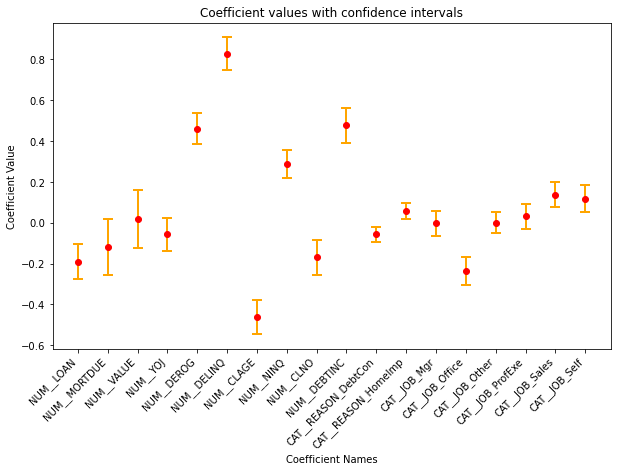

In [127]:
plot_confidence_intervals(coefficent_names, coefficients, lower_interval, upper_interval, flag_scaled = True)

In [144]:
train_scores = list()
test_scores = list()
scores = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
for score in scores:
    train_score, test_score = get_metrics(X_tr, y, model_pipe, score)
    train_scores.append(train_score)
    test_scores.append(test_score)
metrics = pd.DataFrame({'Metric': scores,
                        'Train': train_scores,
                        'Test': test_scores})
display(metrics)

,Metric,Train,Test
0,accuracy,0.841443,0.835906
1,recall,0.329686,0.306889
2,precision,0.725739,0.754966
3,f1,0.453121,0.423462
4,roc_auc,0.809528,0.785681


### Elasticnet

In [132]:
penalty_a='elasticnet'
l1_ratio_value = 0.7
model = LogisticRegression(solver = 'saga', random_state = 23,penalty=penalty_a,l1_ratio=l1_ratio_value)
model_pipe = make_pipeline(StandardScaler(), model)
model_pipe.fit(X_tr, y)

coefficients = model_pipe[-1].coef_[0]
print("Intercept:", model_pipe[-1].intercept_[0])
print("Coefficients:", model_pipe[-1].coef_[0])

Intercept: -1.7304304918971434
Coefficients: [-0.19062531 -0.12205608  0.02258361 -0.05777132  0.46033175  0.82836643
 -0.46165445  0.28953909 -0.1706085   0.47827588 -0.05733953  0.05733953
 -0.00172707 -0.23644665  0.          0.03121837  0.13843186  0.11824901]


In [138]:
# getting confidence interval from coefficents
flow_pipe = make_pipeline(transformer, StandardScaler())
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(flow_pipe, X, y,1000,'elasticnet')
print("Coefficient Confidence Intervals")
print("Lower bound:", lower_ci)
print("Upper bound:", upper_ci)

Coefficient Confidence Intervals
Lower bound: [-0.2890193  -0.26067126 -0.09981089 -0.14493482  0.38788461  0.73738183
 -0.54622944  0.22235007 -0.26649408  0.39230863 -0.0984084   0.0191356
 -0.07462829 -0.34041079 -0.08250775 -0.03279101  0.06259183  0.04886392]
Upper bound: [-0.09713271  0.          0.15638887  0.0267231   0.55828621  0.94070498
 -0.38460761  0.36818934 -0.08376665  0.57917404 -0.0191356   0.0984084
  0.04242009 -0.15670828  0.0407445   0.09970799  0.20679815  0.17565398]


In [139]:
bootstrap = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5%': lower_ci,
                          '97.5%': upper_ci})

bootstrap

,Feature,Coefficient,2.5%,97.5%
0,NUM__LOAN,-0.190625,-0.289019,-0.097133
1,NUM__MORTDUE,-0.122056,-0.260671,0.000000
2,NUM__VALUE,0.022584,-0.099811,0.156389
3,NUM__YOJ,-0.057771,-0.144935,0.026723
4,NUM__DEROG,0.460332,0.387885,0.558286
5,NUM__DELINQ,0.828366,0.737382,0.940705
6,NUM__CLAGE,-0.461654,-0.546229,-0.384608
7,NUM__NINQ,0.289539,0.222350,0.368189
8,NUM__CLNO,-0.170608,-0.266494,-0.083767
9,NUM__DEBTINC,0.478276,0.392309,0.579174


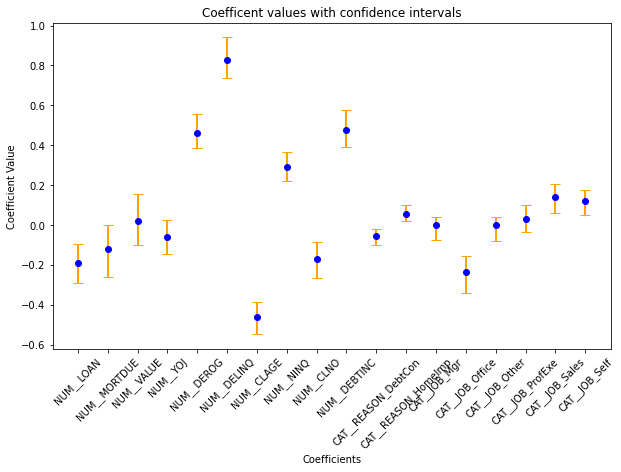

In [140]:
coefficent_names = X_tr.columns
plt.figure(figsize=(10, 6))

plt.errorbar(coefficent_names, coefficients, yerr = [coefficients - lower_ci, upper_ci - coefficients],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coefficients')
plt.ylabel('Coefficient Value')
plt.title('Coefficent values with confidence intervals')

plt.xticks(rotation=45)
plt.savefig("Imagen_Intervalos.png")
plt.show()

In [141]:
# calculating the probabilities
X_sc = model_pipe[0].transform(X_tr)
prob = model_pipe.predict_proba(X_tr)[:, 1]
# getting covariate matrix
W = np.diag(prob * (1 - prob))
# calculating the standard deviation
std = np.sqrt(np.diag(np.linalg.pinv(np.dot(np.dot(X_sc.T, W), X_sc))))
# getting confidence intervals
lower_interval = coefficients - np.abs(norm.ppf(0.025)) * std
upper_interval = coefficients + np.abs(norm.ppf(0.025)) * std

In [142]:
intervalos = pd.DataFrame({'Feature':X_tr.columns.tolist(),
                         'Coefficient': coefficients,
                          '2.5% Boost': lower_ci,
                          '97.5% Boost': upper_ci,
                          '2.5% Mate': lower_interval,
                          '97.5% Mate': upper_interval})

intervalos

,Feature,Coefficient,2.5% Boost,97.5% Boost,2.5% Mate,97.5% Mate
0,NUM__LOAN,-0.190625,-0.289019,-0.097133,-0.275470,-0.105780
1,NUM__MORTDUE,-0.122056,-0.260671,0.000000,-0.258752,0.014640
2,NUM__VALUE,0.022584,-0.099811,0.156389,-0.119975,0.165143
3,NUM__YOJ,-0.057771,-0.144935,0.026723,-0.139939,0.024396
4,NUM__DEROG,0.460332,0.387885,0.558286,0.383889,0.536775
5,NUM__DELINQ,0.828366,0.737382,0.940705,0.748252,0.908481
6,NUM__CLAGE,-0.461654,-0.546229,-0.384608,-0.544969,-0.378340
7,NUM__NINQ,0.289539,0.222350,0.368189,0.220224,0.358854
8,NUM__CLNO,-0.170608,-0.266494,-0.083767,-0.254878,-0.086339
9,NUM__DEBTINC,0.478276,0.392309,0.579174,0.393719,0.562832


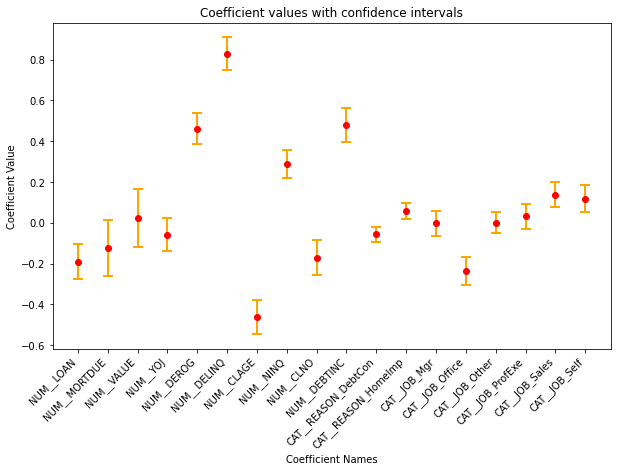

In [143]:
plot_confidence_intervals(coefficent_names, coefficients, lower_interval, upper_interval, flag_scaled = True)

In [168]:
model = LogisticRegression(solver = 'saga', random_state = 23, penalty = None)
regular_pipe = make_pipeline(StandardScaler(), model)
train_scores = list()
test_scores = list()
scores = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
for score in scores:
    train_score, test_score = get_metrics(X_tr, y, regular_pipe, score)
    train_scores.append(train_score)
    test_scores.append(test_score)

metrics = pd.DataFrame({'Metric': scores, 
                        'Train': train_scores,
                        'Test': test_scores})
display(metrics)

,Metric,Train,Test
0,accuracy,0.841275,0.836074
1,recall,0.330527,0.308574
2,precision,0.723557,0.754244
3,f1,0.453520,0.425126
4,roc_auc,0.809492,0.785519


# Verifying assumptions

Fitting selected model

In [172]:
regular_pipe.fit(X_tr, y)
X_sc = pd.DataFrame(regular_pipe[0].transform(X_tr), columns = X_tr.columns)

**Target Assumption (Bernoulli Distribution)**

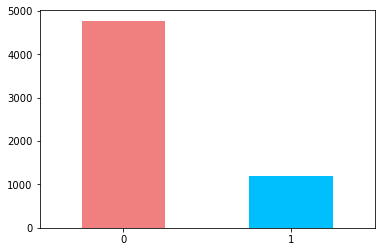

In [173]:
y.value_counts().plot(kind = 'bar', rot = 0, color = ['lightcoral', 'deepskyblue'])
plt.show()

**Indepence of Observations Assumption**

In [174]:
_, p_value, _, _ = chi2_contingency(X_tr)

print("Chi-square p-value test:", p_value)

Chi-square p-value test: 0.0


**Absence of Multicolinearity**

In [175]:
# numerical values
num_col = [column for column in X_tr.columns if 'NUM' in column]
num_values = X_tr[num_col].values
# VIF dataframe 
vif_data = pd.DataFrame()
vif_data["feature"] = num_col
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(num_values, i) 
                          for i in range(len(num_col))]

display(vif_data)

,feature,VIF
0,NUM__LOAN,5.504762
1,NUM__MORTDUE,16.599262
2,NUM__VALUE,20.647647
3,NUM__YOJ,2.604697
4,NUM__DEROG,1.142806
5,NUM__DELINQ,1.213577
6,NUM__CLAGE,6.507489
7,NUM__NINQ,1.830566
8,NUM__CLNO,7.698969
9,NUM__DEBTINC,11.498306


**Linearity of log odds and Independent Features Assumption**

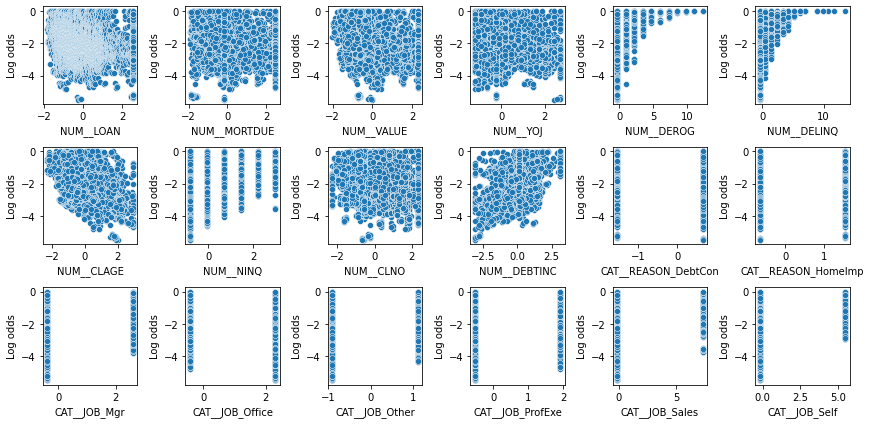

In [176]:
fig, axis = plt.subplots(3, 6, figsize = (12, 6))
log_odds = regular_pipe.predict_log_proba(X_tr)[:, 1]
for index, column in enumerate(X_sc.columns.tolist()):
    row = index // 6
    col = index % 6
    ax = axis[row][col]
    sns.scatterplot(x = X_sc[column], y = log_odds, ax = ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Log odds')
plt.tight_layout()
plt.show()

**Great sample size Assumption**

In [177]:
n_features = len(X_tr.columns)
p_lower = y.mean()
optimal_size = int(np.ceil((10 * n_features / p_lower)))
X_tr.shape[0] > optimal_size

True

## USE CASE

<div style="text-align: justify">
As the banks desire to understand how much their Expected Credit Loss (ECL) will vary, they analyze their possibilities with three
scenarios: base, optimistic, and pessimistic. This is achieved by considering the lower and upper edges of the coefficient confidence intervals. Finally, a weighted average is performed to obtain a unique value known as the normal scenario. To facilitate the calculation, it is assumed that the two parameters of the ECL, Loss Given Default (LGD) and Exposure at Default (EAD), are fixed at $1,000,000.00. Therefore, the Probability of Default (PD) is the variable used to explore different scenarios. This probability is obtained by quantiling 0.5 the entire dataset's output by considering it belongs to the first Q.
</div>

In [155]:
# defining a function to calculate probability
def sigmoid(betas, X):
    return 1 / (1 + np.exp(-(np.dot(X_sc, betas))))

In [156]:
# declaring fixed parameters
amount = 1000000
# calculating per scenario
prob_base = np.quantile(sigmoid(coefficients, X_sc), 0.5)
prob_opti = np.quantile(sigmoid(upper_interval, X_sc), 0.5)
prob_pesi = np.quantile(sigmoid(lower_interval, X_sc), 0.5)

Using the 2020 probabilities to compute the normal escenario

| Portfolio Scenario | Average Weights in 2019 | Average Weights in 2020 |
|:-------------------:|:-----------------------:|:-----------------------:|
| Optimistic          |           18%           |           18%           |
| Base                |           59%           |           56%           |
| Pessimistic         |           23%           |           26%           |

In [157]:
prob_normal = 0.18 * prob_opti + 0.56 * prob_base + 0.26 * prob_pesi

Finally, the ECL is calculated on each scenario

In [158]:
ecl_normal = prob_normal * amount
ecl_base = prob_base * amount
ecl_optimistic = prob_opti * amount
ecl_pessimistic = prob_pesi * amount
ecl_tbl = pd.DataFrame({'Scenario': ['Normal', 'Base', 'Optimistic', 'Pessimistic'],
                      'ECL': [ecl_normal, ecl_base, ecl_optimistic, ecl_pessimistic]})

Plotting results

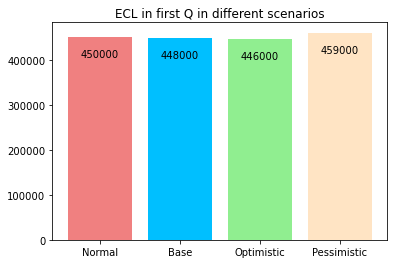

In [159]:
colors = ['lightcoral', 'deepskyblue', 'lightgreen', 'bisque']
plt.bar(ecl_tbl.Scenario, ecl_tbl.ECL, color = colors)
plt.title('ECL in first Q in different scenarios')
for x_pos, y_pos in enumerate(ecl_tbl.ECL.values.tolist()):
    plt.text(x_pos, 0.9 * y_pos, round((y_pos // 1000) * 1000), ha = 'center')
plt.show()

<AxesSubplot:>

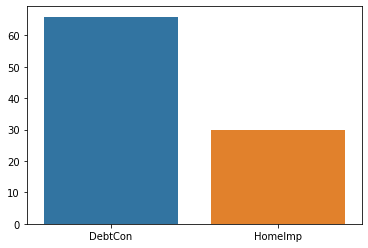

In [27]:
percentages = (Base['REASON'].value_counts() / len(Base)) * 100
sns.barplot(x=percentages.index, y=percentages.values)

<AxesSubplot:>

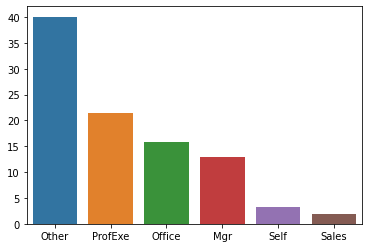

In [30]:
percentages = (Base['JOB'].value_counts() / len(Base)) * 100
sns.barplot(x=percentages.index, y=percentages.values)

In [43]:
Base[Base['CLAGE']<450]['CLAGE'].describe()

count    5623.000000
mean      177.502074
std        79.142034
min         0.000000
25%       114.906479
50%       172.767888
75%       230.254451
max       440.421254
Name: CLAGE, dtype: float64

In [44]:
Imputar_CLAGE=Base[Base['CLAGE']<450]['CLAGE'].mean()
print(Imputar_Value)
Base['CLAGE'] =  np.where(Base['CLAGE']>450,Imputar_CLAGE,Base['CLAGE'])
Base['CLAGE'] = np.where(Base['CLAGE'].isnull(), 150, Base['CLAGE'])

29800.0


In [45]:
print(Base[Base['NINQ'].isna()].shape[0]/Base.shape[0])
Base[Base['NINQ'].isna()]

0.08557046979865772


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3,1,1500.000000,16262.771937,25000.0,DebtCon,Other,9.362174,NaN,0.0,150.000000,NaN,NaN,NaN
10,1,2000.000000,22608.000000,25000.0,DebtCon,Other,18.000000,NaN,0.0,150.000000,NaN,NaN,NaN
17,1,2200.000000,23030.000000,25000.0,DebtCon,Other,19.000000,NaN,0.0,150.000000,NaN,NaN,3.711312
51,0,3100.000000,16262.771937,29800.0,DebtCon,Other,9.362174,NaN,0.0,150.000000,NaN,NaN,NaN
63,1,3600.000000,16262.771937,29800.0,HomeImp,ProfExe,10.000000,NaN,0.0,150.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,0,16935.114236,16262.771937,29800.0,DebtCon,Other,9.362174,5.0,0.0,116.437035,NaN,19.0,26.070435
5762,0,16935.114236,16262.771937,29800.0,DebtCon,Other,9.362174,5.0,0.0,130.496983,NaN,19.0,27.105116
5765,0,16935.114236,16262.771937,29800.0,DebtCon,Other,9.362174,5.0,0.0,128.656393,NaN,20.0,28.187140
5808,1,16935.114236,16262.771937,29800.0,HomeImp,Other,1.300000,0.0,1.0,103.133333,NaN,13.0,NaN


In [47]:
Imputar_NINQ=Base[Base['NINQ']<10]['NINQ'].mean()
print(Imputar_NINQ)
Base['NINQ'] =  np.where(Base['NINQ']>10,Imputar_NINQ,Base['NINQ'])
Base['NINQ'] = np.where(Base['NINQ'].isnull(), 5, Base['NINQ'])

1.108583055863855


In [48]:
Base['CLNO'].unique()

array([ 9., 14., 10., nan,  8., 17., 12., 13., 25., 24., 16., 22.,  0.,
        4., 21., 19., 45., 26., 37.,  3.,  2., 27., 20.,  7., 36., 33.,
        6., 28., 11., 31., 15., 18., 23.,  5., 30., 34., 42., 50., 47.,
       32., 29., 46., 38., 40., 49., 43., 35.,  1., 56., 39., 51., 55.,
       65., 57., 41., 71., 48., 53., 64., 52., 63., 44., 58.])

In [49]:
Base['MORTDUE'].describe()

count     5960.000000
mean     16265.703893
std       1653.534536
min       2063.000000
25%      16262.771937
50%      16262.771937
75%      16262.771937
max      25000.000000
Name: MORTDUE, dtype: float64

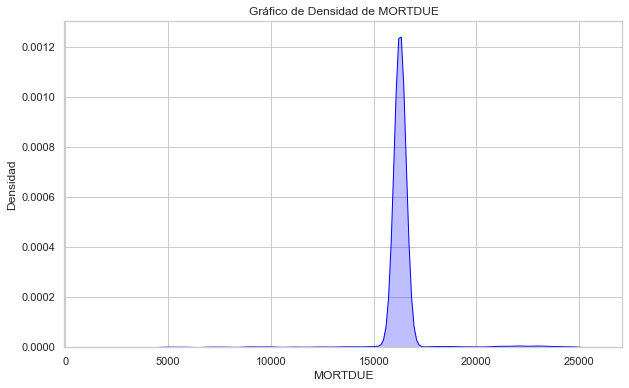

In [50]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(data=Base['MORTDUE'], fill=True, color="blue")

plt.title("Gráfico de Densidad de MORTDUE")
plt.xlabel("MORTDUE")
plt.ylabel("Densidad")

plt.show()

In [51]:
Base[Base['DEBTINC'].isna()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100.000000,16262.771937,29800.0,HomeImp,Other,10.500000,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300.000000,16262.771937,29800.0,HomeImp,Other,7.000000,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500.000000,13500.000000,16700.0,HomeImp,Other,4.000000,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500.000000,16262.771937,25000.0,DebtCon,Other,9.362174,NaN,0.0,150.000000,5.0,NaN,NaN
4,0,1700.000000,16262.771937,29800.0,HomeImp,Office,3.000000,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,1,16935.114236,16262.771937,29800.0,DebtCon,Other,1.000000,0.0,0.0,117.166667,9.0,23.0,NaN
5932,1,16935.114236,16262.771937,29800.0,DebtCon,Other,12.000000,0.0,0.0,134.900000,0.0,26.0,NaN
5933,1,16935.114236,16262.771937,29800.0,HomeImp,Self,8.000000,1.0,2.0,71.533132,3.0,14.0,NaN
5935,0,16935.114236,13900.000000,29800.0,HomeImp,Other,27.000000,0.0,1.0,138.000000,0.0,14.0,NaN


In [52]:
print(Base[Base['DEBTINC'].isna()].shape)

(1267, 13)


In [53]:
bins = [0, 5000,10000,15000,20000,float('inf')] 
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k+']
Base['MORTDUE_Rango'] = pd.cut(Base['MORTDUE'], bins=bins, labels=labels, include_lowest=True)
media_debtinc_por_rango = Base.groupby('MORTDUE_Rango')['DEBTINC'].mean()

In [54]:
media_debtinc_por_rango

MORTDUE_Rango
0-5k       40.836453
5k-10k     26.971794
10k-15k    29.518648
15k-20k    34.010981
20k+       30.286589
Name: DEBTINC, dtype: float64

In [55]:
media_por_rango = {}
for rango in labels:
    media = Base[Base['MORTDUE_Rango'] == rango]['DEBTINC'].mean()
    media_por_rango[rango] = media
media_por_rango

{'0-5k': 40.836452556,
 '5k-10k': 26.971793721019594,
 '10k-15k': 29.518648409799997,
 '15k-20k': 34.0109811076626,
 '20k+': 30.286588966964054}

In [56]:
for rango, media in media_por_rango.items():
    Base.loc[(Base['DEBTINC'].isnull()) & (Base['MORTDUE_Rango'] == rango), 'DEBTINC'] = media

In [60]:
Base.DEROG.unique()

array([ 0., nan,  3.,  2.,  1.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

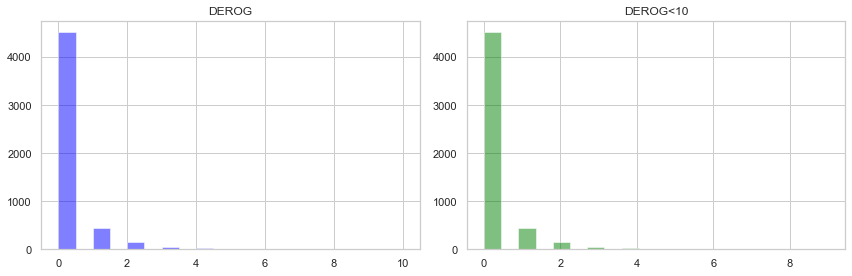

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(Base['DEROG'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('DEROG')
axes[1].hist(Base[Base['DEROG']<10]['DEROG'], bins=20, color='green', alpha=0.5)
axes[1].set_title('DEROG<10')
plt.tight_layout()
plt.show()

In [61]:
#Base['DEROG'] =  np.where(Base['NINQ']>10,Imputar_NINQ,Base['NINQ'])
Base['DEROG'] = np.where(Base['DEROG'].isnull(), 0, Base['DEROG'])

In [62]:
Base.isnull().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO             222
DEBTINC            0
MORTDUE_Rango      0
dtype: int64

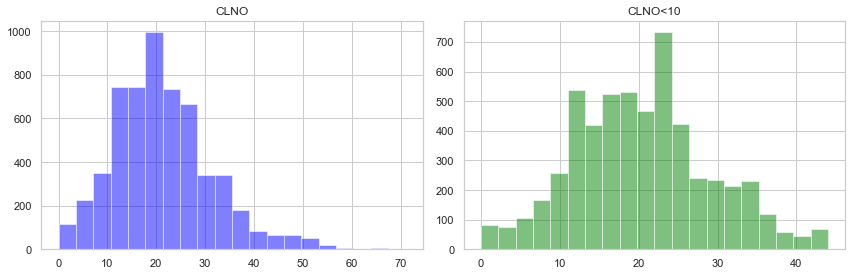

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(Base['CLNO'], bins=20, color='blue', alpha=0.5)
axes[0].set_title('CLNO')
axes[1].hist(Base[Base['CLNO']<45]['CLNO'], bins=20, color='green', alpha=0.5)
axes[1].set_title('CLNO<10')
plt.tight_layout()
plt.show()

In [64]:
Q1 = Base['CLNO'].describe()['25%']
Q3 = Base['CLNO'].describe()['75%']
IQR = Q3 - Q1

print("Primer cuartil (Q1):", Q1)
print("Tercer cuartil (Q3):", Q3)
print("Rango Intercuartílico (IQR):", IQR)

Q3+1.5*IQR,Q3-1.5*IQR

Primer cuartil (Q1): 15.0
Tercer cuartil (Q3): 26.0
Rango Intercuartílico (IQR): 11.0


(42.5, 9.5)

In [67]:
Imputar_CLNO=Base[Base['CLNO']<45]['CLNO'].mean()
print(Imputar_CLNO)
Base['CLNO'] =  np.where(Base['CLNO']>45,Imputar_CLNO,Base['CLNO'])
Base['CLNO'] = np.where(Base['CLNO'].isnull(), 5, Base['CLNO'])

20.296917252568957


In [68]:
Base.isnull().sum()

BAD              0
LOAN             0
MORTDUE          0
VALUE            0
REASON           0
JOB              0
YOJ              0
DEROG            0
DELINQ           0
CLAGE            0
NINQ             0
CLNO             0
DEBTINC          0
MORTDUE_Rango    0
dtype: int64

In [85]:
Base_F = pd.merge(Base, pd.get_dummies(Base[['JOB','REASON','MORTDUE_Rango']]), left_index=True, right_index=True)
Base_F

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,JOB_ProfExe,JOB_Sales,JOB_Self,REASON_DebtCon,REASON_HomeImp,MORTDUE_Rango_0-5k,MORTDUE_Rango_5k-10k,MORTDUE_Rango_10k-15k,MORTDUE_Rango_15k-20k,MORTDUE_Rango_20k+
0,1,1100.000000,16262.771937,29800.0,HomeImp,Other,10.500000,0.0,0.0,94.366667,...,0,0,0,0,1,0,0,0,1,0
1,1,1300.000000,16262.771937,29800.0,HomeImp,Other,7.000000,0.0,2.0,121.833333,...,0,0,0,0,1,0,0,0,1,0
2,1,1500.000000,13500.000000,16700.0,HomeImp,Other,4.000000,0.0,0.0,149.466667,...,0,0,0,0,1,0,0,1,0,0
3,1,1500.000000,16262.771937,25000.0,DebtCon,Other,9.362174,0.0,0.0,150.000000,...,0,0,0,1,0,0,0,0,1,0
4,0,1700.000000,16262.771937,29800.0,HomeImp,Office,3.000000,0.0,0.0,93.333333,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,16935.114236,16262.771937,29800.0,DebtCon,Other,16.000000,0.0,0.0,221.808718,...,0,0,0,1,0,0,0,0,1,0
5956,0,16935.114236,16262.771937,29800.0,DebtCon,Other,16.000000,0.0,0.0,208.692070,...,0,0,0,1,0,0,0,0,1,0
5957,0,16935.114236,16262.771937,29800.0,DebtCon,Other,15.000000,0.0,0.0,212.279697,...,0,0,0,1,0,0,0,0,1,0
5958,0,16935.114236,16262.771937,29800.0,DebtCon,Other,14.000000,0.0,0.0,213.892709,...,0,0,0,1,0,0,0,0,1,0


In [86]:
Base_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   BAD                    5960 non-null   int64   
 1   LOAN                   5960 non-null   float64 
 2   MORTDUE                5960 non-null   float64 
 3   VALUE                  5960 non-null   float64 
 4   REASON                 5960 non-null   object  
 5   JOB                    5960 non-null   object  
 6   YOJ                    5960 non-null   float64 
 7   DEROG                  5960 non-null   float64 
 8   DELINQ                 5960 non-null   float64 
 9   CLAGE                  5960 non-null   float64 
 10  NINQ                   5960 non-null   float64 
 11  CLNO                   5960 non-null   float64 
 12  DEBTINC                5960 non-null   float64 
 13  MORTDUE_Rango          5960 non-null   category
 14  JOB_Mgr                5960 non-null   u

In [87]:
X=Base_F.drop(['BAD','REASON','JOB','MORTDUE_Rango'],axis=1)
y=Base_F[['BAD']]
print(X.shape,y.shape)

(5960, 23) (5960, 1)


In [88]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

print("Intercepto:", model.intercept_[0])
import warnings
print("Coeficientes:", model.coef_[0])

Intercepto: 0.0009566097258696862
Coeficientes: [-3.31821353e-05  1.03706040e-04 -1.32877420e-04 -1.43514585e-03
  3.37101608e-02  6.06117003e-02 -5.37247847e-03  2.75711511e-02
 -2.02067496e-03  6.48620210e-02  1.91867076e-03 -4.35453126e-03
  2.07350184e-03 -1.13247910e-03  1.03123324e-03  1.42021425e-03
 -8.01551234e-04  1.75816096e-03  4.51066736e-04  9.06303611e-04
  5.14261762e-04 -5.45400598e-04 -3.69621785e-04]


/Users/jorgefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [90]:

model = LogisticRegression(solver='liblinear')
model.fit(X, y)

print("Intercepto:", model.intercept_[0])

print("Coeficientes:", model.coef_[0])

def bootstrap_confidence_interval_logistic(X, y, num_simulations=10000):
    coefs = []
    num_samples = len(X)
    for _ in range(num_simulations):
        # Muestreo bootstrap
        idx = np.random.choice(range(num_samples), size=num_samples, replace=True)
        X_sampled, y_sampled = X.iloc[idx], y.iloc[idx]
        
        # Ajustar el modelo en la muestra
        model.fit(X_sampled, y_sampled)
        coefs.append(model.coef_[0])
    
    coefs = np.array(coefs)
    lower_percentile = np.percentile(coefs, 2.5, axis=0)
    upper_percentile = np.percentile(coefs, 97.5, axis=0)
    
    return lower_percentile, upper_percentile

# Obtener intervalos de confianza de los coeficientes
lower_ci, upper_ci = bootstrap_confidence_interval_logistic(X, y)

print("Intervalos de confianza de los coeficientes:")
print("Intervalo Inferior:", lower_ci)
print("Intervalo Superior:", upper_ci)

Intervalos de confianza de los coeficientes:
Intervalo Inferior: [-4.36411928e-05  5.02451990e-05 -1.79516504e-04 -1.97396258e-02
  1.54275639e-02  2.79622132e-02 -6.74291519e-03  1.28515057e-02
 -2.06657266e-02  3.83818022e-02  1.65021594e-04 -1.37462428e-01
 -5.78469416e-03 -2.24853280e-02  4.25109540e-04  5.99350768e-04
 -5.07216436e-02  1.25986666e-04  1.72332136e-04  3.46457002e-04
  5.74702506e-05 -3.92371045e-02 -1.26302703e-02]
Intervalo Superior: [-2.23883527e-05  1.57489802e-04 -9.96318825e-05  1.44792982e-02
  5.52015919e-01  7.86299813e-01 -4.46796242e-03  1.42340516e-01
  1.66402290e-02  8.87671034e-02  5.03792584e-02 -1.92496677e-03
  5.63000464e-02  2.74256975e-02  4.55236665e-02  4.99586612e-02
  6.75559696e-03  7.12842026e-02  1.49429116e-02  3.41008039e-02
  1.76157434e-02  1.84540484e-03  8.96261256e-03]


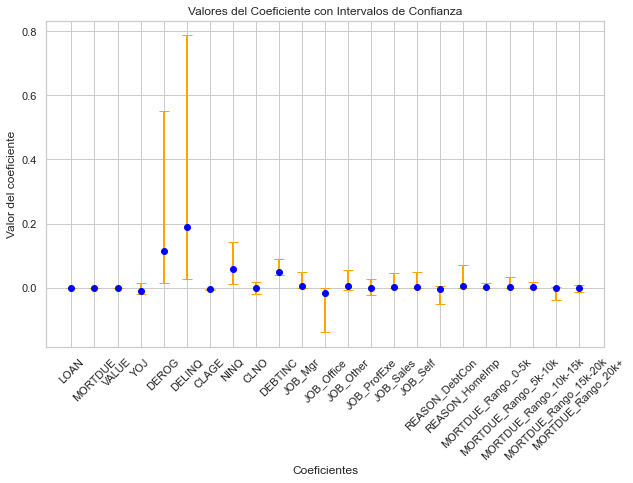

In [94]:
coeficientes = model.coef_[0]
nombres_coeficientes=X.columns
plt.figure(figsize=(10, 6))

plt.errorbar(nombres_coeficientes, coeficientes, yerr=[coeficientes - lower_ci, upper_ci - coeficientes],
             fmt='o', color='blue', ecolor='orange', capsize=5, elinewidth=2)

plt.xlabel('Coeficientes')
plt.ylabel('Valor del coeficiente')
plt.title('Valores del Coeficiente con Intervalos de Confianza')

plt.xticks(rotation=45)  # Rotación de las etiquetas del eje x para una mejor visualización

plt.show()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

model = smf.ols('y ~ X', data=X.columns).fit()  # Ejemplo para regresión lineal

# O suponiendo que has ajustado el modelo directamente con sm (sm.OLS o sm.Logit)
model = sm.OLS(y, X).fit()  # Ejemplo para regresión lineal

# Obtener el resumen del modelo
summary = model.summary()

# Obtener los coeficientes y sus intervalos de confianza del resumen del modelo
conf_int = summary.tables[1]  # Obtener la segunda tabla del resumen que contiene los coeficientes e intervalos de confianza
conf_int = pd.DataFrame(conf_int.data[1:], columns=conf_int.data[0])  # Convertir la tabla en un DataFrame

print(conf_int)
